In [50]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from matplotlib.colors import Normalize

# To Do
* Put GTEx demo spreadsheet into data
* Put GTEx expression spreadsheet (OR LINK) into data
* Put GTEx demo 2 spreadsheet into data
* Put GTEx exclusion spreadsheet into data
* Put GTEx gene spreadsheet into data
* Link "comps" df path to path generated from previous notebook
* Change all the spreadsheet paths
* Add script to prep GTEx data
* Add instructions about the spreadsheet

# Prep data

### Instructions
Add info here about:
* The different spreadsheets and what's in them
* The scripts used to process them
* Source (papers, download locations, etc)

In [3]:
# edit this 
df = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress_meta.csv')

In [67]:
df.shape

(2483, 20)

In [4]:
## Need to add some extra information to the spreadsheet
##!! Note-to-self are we allowed to use this stuff? Is it all necessary?
bwdf = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_meta_forJake.csv')
bwcols = ['AGE','brainweight', 'weight','height', 'race', 'ethnicity']
df.loc[:,'merger'] = ['%s_%s'%(df.loc[x,'SUBJID'],
                               df.loc[x,'SMTSD']) for x in df.index]
bwdf.loc[:,'merger'] = ['%s_%s'%(bwdf.loc[x,'SUBJID'],
                               bwdf.loc[x,'SMTSD']) for x in bwdf.index]
jnk = pandas.DataFrame(df,copy=True)
jnk.loc[:,'old_ind'] = jnk.index.values
jnk.index = jnk.merger.values
bwdf.index = bwdf.merger.values
shared = list(set(bwdf.index) & set(jnk.index))
for col in bwcols:
    jnk.loc[shared,col] = bwdf.loc[shared,col].values
    df.loc[:,col] = jnk.loc[:,col].values

In [6]:
# number of samples
len(df.SUBJID.unique())

376

We also want to make sure that our results aren't driven by individuals with brain diseases. Another recent paper (!!ADD REF!!) recommended an extreme processing stream for the GTEx that, among other rather heavy-handed steps, excluded all individuals who died of/with brain disease. 

Attached is a spreadsheet of GTEx data after this preprocessing was done. By cross-referencing out spreadsheet (with everyone) with the post-processed spreadsheet (without individuals with brain disease), we can ID who is who

In [7]:
excludf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTEx/GTEx_meta.csv',index_col=0)
dx_exclude = list(set(df.SUBJID.values) - set(excludf.SUBJID.values))
df.loc[df.SUBJID.isin(dx_exclude),'Excl_Dx'] = 1
df.loc[df.Excl_Dx!=1,'Excl_Dx'] = 0

In [9]:
# Brain regions
df.SMTSD.value_counts()

Brain - Cortex                               255
Brain - Caudate (basal ganglia)              246
Brain - Nucleus accumbens (basal ganglia)    246
Brain - Cerebellum                           241
Brain - Cerebellar Hemisphere                215
Brain - Frontal Cortex (BA9)                 209
Brain - Putamen (basal ganglia)              205
Brain - Hypothalamus                         202
Brain - Hippocampus                          197
Brain - Anterior cingulate cortex (BA24)     176
Brain - Amygdala                             152
Brain - Substantia nigra                     139
Name: SMTSD, dtype: int64

In [21]:
exp = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress.csv')

In [11]:
exp.shape

(15758, 2484)

In [22]:
exp.columns = ['ENSGID'] + exp.columns[1:].tolist()

In [13]:
genes = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/genes_forJake.csv')
genes

,hgnc_symbol,ensembl_gene_id,chromosome_name,start_position,end_position,entrezgene_id
0,FGR,ENSG00000000938,1,27612064,27635185,2268.0
1,STPG1,ENSG00000001460,1,24356999,24416934,90529.0
2,NIPAL3,ENSG00000001461,1,24415802,24472976,57185.0
3,AK2,ENSG00000004455,1,33007940,33080996,204.0
4,KDM1A,ENSG00000004487,1,23019443,23083689,23028.0
...,...,...,...,...,...,...
15738,NaN,ENSG00000280216,22,39379610,39380015,NaN
15739,NaN,ENSG00000281538,22,42138060,42139726,NaN
15740,NaN,ENSG00000283366,22,19014353,19014506,NaN
15741,NaN,ENSG00000283438,22,23132730,23133005,NaN


# Whole dataset congruence

Here, we will match the GTEx genes with the Allen genes in order to derive PLS components for GTEx samples

In [14]:
gdict = dict(zip(genes.ensembl_gene_id.values,
                genes.hgnc_symbol.values))
gmatch = [np.nan if x not in gdict.keys() else \
          gdict[x] for x in exp.ENSGID.values]

In [23]:
exp.loc[:,'gene_symbol'] = gmatch
exp.dropna(inplace=True)

In [16]:
# NOTE: This spreadsheet was generated from notebook: 
comps = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/PLS_Component_Expr.csv')
comps.head()

,gene_symbol,gene_name,C1_expr,C2_expr,C3_expr
0,A1BG,alpha-1-B glycoprotein,0.001517,0.006065,-0.020001
1,A1BG-AS1,NaN,-0.006685,-0.006733,-0.002762
2,A2M,alpha-2-macroglobulin,0.005135,0.007225,0.002345
3,A2ML1,alpha-2-macroglobulin-like 1,-0.009261,-0.004295,-0.010945
4,A3GALT2,NaN,-0.001305,-0.000388,-0.000463


#### Match genes

In [24]:
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
len(shared_genes)

12647

In [25]:
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
                                 copy=True)
exp = pandas.DataFrame(exp[exp.gene_symbol.isin(shared_genes)],
                                copy=True)

In [26]:
egenes = exp.gene_symbol.values

In [27]:
exp.shape

(12647, 2485)

In [28]:
matched_comps.shape

(12647, 5)

In [136]:
# shared_genes = list(set(comps.gene_symbol) & set(matched_genes.hgnc_symbol))
# matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
#                                  copy=True)
# rematched_genes = pandas.DataFrame(matched_genes[matched_genes.hgnc_symbol.isin(shared_genes)],
#                                 copy=True)

In [142]:
# exp = exp.loc[rematched_genes.index]

#### regress covariates

Here we are going to regress out the first five "Sequence PCs" from the data. These are PCs derived from confounding covariates, as described in (!!REF!!). 

In [33]:
df.columns[8:13]

Index(['SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'], dtype='object')

In [35]:
# This took a few minute on my computer
nexp = np.zeros_like(exp.iloc[:,1:-1].values)
dat = pandas.DataFrame(df[df.columns[8:13]],copy=True)
count = 0
for i,row in exp.iterrows():
    dat.loc[:,'exp'] = row.values[1:-1].astype(float)
    mod = smf.ols('exp ~ SeqPC1 + SeqPC2 + SeqPC3 + SeqPC4 + SeqPC5',
                  data=dat).fit()
    nexp[count,:] = mod.resid.values
    if count%100==0:
        print('finished %s of %s'%(count+1,len(nexp)))
    count+=1

finished 1 of 12647
finished 101 of 12647
finished 201 of 12647
finished 301 of 12647
finished 401 of 12647
finished 501 of 12647
finished 601 of 12647
finished 701 of 12647
finished 801 of 12647
finished 901 of 12647
finished 1001 of 12647
finished 1101 of 12647
finished 1201 of 12647
finished 1301 of 12647
finished 1401 of 12647
finished 1501 of 12647
finished 1601 of 12647
finished 1701 of 12647
finished 1801 of 12647
finished 1901 of 12647
finished 2001 of 12647
finished 2101 of 12647
finished 2201 of 12647
finished 2301 of 12647
finished 2401 of 12647
finished 2501 of 12647
finished 2601 of 12647
finished 2701 of 12647
finished 2801 of 12647
finished 2901 of 12647
finished 3001 of 12647
finished 3101 of 12647
finished 3201 of 12647
finished 3301 of 12647
finished 3401 of 12647
finished 3501 of 12647
finished 3601 of 12647
finished 3701 of 12647
finished 3801 of 12647
finished 3901 of 12647
finished 4001 of 12647
finished 4101 of 12647
finished 4201 of 12647
finished 4301 of 12647


In [36]:
exp = pandas.DataFrame(nexp,index=exp.index,columns=exp.columns[1:-1])

#### get expression of each component for each GTex sample

In [37]:
exp.loc[:,'gene_symbol'] = egenes

In [38]:
exp.sort_values('gene_symbol',inplace=True)

In [65]:
# You might want to save this so you dont have to run the regression again
# If so, change the path to fit your desired location
#exp.to_csv('/Users/jacobv/Science/PLS_GXP/GTex_harmed_GExp.csv')

# Analyses -- replication

The objective here is to see if the PLS Components derived in AHBA "reproduce" in GTEx. 

The way we're doing this is taking the PLS Model trained on Allen data and applying it to the GTEx data. We compare the "predicted" GTEx data based on gene expression to the predicted Allen data by correlating the predicted values of both datasets across regions. The reason this works is because Y is spatial location, and regions are spatially embedded.

So, what we are essentially doing here is just ensuring that the genes expressed in the Allen PLS Components are expressed in a similar regional pattern in GTEx as they are in AHBA. Another way to think about it is we are looking to see how similar the two are datasets with a specific focus on the expression of genes contributing to the AHBA PLS Components. See C_XSpecies.ipynb for different null models.

This is an important step because a) we see how robust the regional expression of PLS Components in a separate dataset, and b) it is necessary to show a very high correlation across datasets if we want to look at how the PLS Components vary over age in the GTEx dataset.

In [40]:
# Load the data if it was already saved
# change path
exp = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTex_harmed_GExp.csv',
                     index_col=0)

In [41]:
# create dataframe with the important columns
scols = exp.columns[:-1]
pred = pandas.DataFrame()
for i in range(1,4):
    pred.loc[:,'C%s'%i] = np.dot(exp[scols].values.T,
                                 matched_comps['C%s_expr'%i])
pred.loc[:,'sample'] = scols
pred.loc[:,'Region'] = df.loc[:,'SMTSD'].values

In [43]:
# Make a mapping between GTEx brain regions and AHBA divisions
rkey = dict(zip(pred.Region.unique(),
               ['Frontal','Cerebellum','Frontal','Caudate','Accumbens',
               'Putamen','Hypothalamus','Hippocampus','AntCing',
               'Cerebellum','Nigra','Amygdala']))

In [44]:
# add to new dataframe
for i,row in pred.iterrows():
    pred.loc[i,'Div'] = rkey[row['Region']]

In [45]:
# How are we doing
pred.head()

,C1,C2,C3,sample,Region,Div
0,-6.666732,-7.399462,-1.290747,GTEX-1117F-3226-SM-5N9CT,Brain - Cortex,Frontal
1,-7.945171,-4.575685,-2.022463,GTEX-111FC-3126-SM-5GZZ2,Brain - Cortex,Frontal
2,15.704045,-3.350887,3.526193,GTEX-111FC-3326-SM-5GZYV,Brain - Cerebellum,Cerebellum
3,-14.417177,-11.016445,-0.411719,GTEX-1128S-2726-SM-5H12C,Brain - Cortex,Frontal
4,10.318082,-8.163148,3.776098,GTEX-1128S-2826-SM-5N9DI,Brain - Cerebellum,Cerebellum


We want to be able to test how robust the reproducibility is to age of the sample (everyone vs only those in the AHBA age range), cognitive status (everyone vs only those w/o brain disorder at death), and the interaction of these features.

So, we'll create separate subsamples that include:
* full -- Everyone
* younger -- everyone <= 60
* ctrl -- all "controls" (weren't excluded by stringent pipeline)
* yctrl -- all "controls" <= 60

In [46]:
# create these "datasets"
younger = df[df.AGE<61][df.columns[0]].values
cntrl = df[df.Excl_Dx==0][df.columns[0]].values
datasets = {'full': pred.groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'younger': pred[pred['sample'].isin(younger)
                                 ].groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'ctrl': pred[pred['sample'].isin(cntrl)
                        ].groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'yctrl': pred[(pred['sample'].isin(cntrl)) & (pred['sample'].isin(younger))
                        ].groupby('Div')[['C1','C2','C3']].mean().sort_index()
           }
for nm,gtC in datasets.items():
    gtC.loc[:,'GTeX_div'] = gtC.index
    
# show an example
datasets['full']

,C1,C2,C3,GTeX_div
Div,,,,
Accumbens,-5.856480,6.371023,-3.089193,Accumbens
Amygdala,-1.096456,2.506232,-5.053756,Amygdala
AntCing,-11.886095,-1.131183,-2.957958,AntCing
Caudate,-3.830412,6.733225,0.509462,Caudate
Cerebellum,16.099663,-9.856331,2.932585,Cerebellum
Frontal,-14.749473,-6.937680,-2.318419,Frontal
Hippocampus,0.611907,0.569835,-1.870727,Hippocampus
Hypothalamus,8.477406,11.268822,3.917789,Hypothalamus
Nigra,17.927024,10.937031,8.353154,Nigra


========== full ==========
r = 0.945, p = 0.0


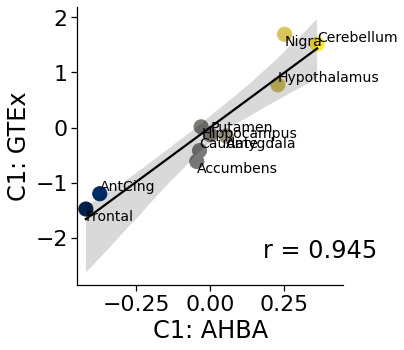

r = 0.965, p = 0.0


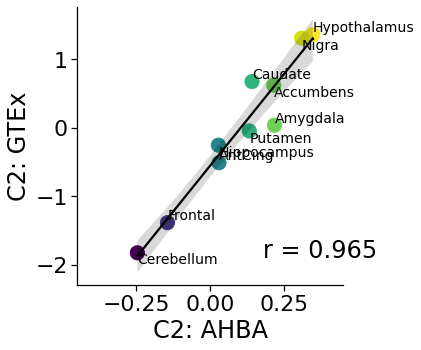

r = 0.865, p = 0.001


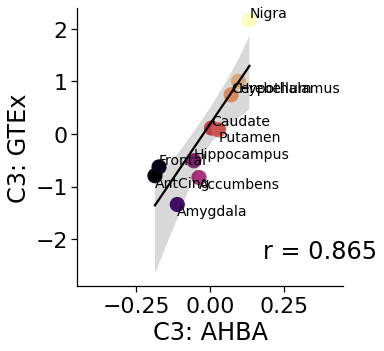

========== younger ==========
r = 0.95, p = 0.0


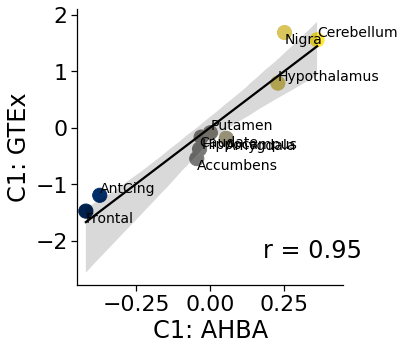

r = 0.97, p = 0.0


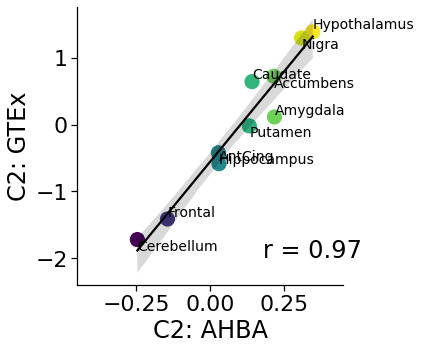

r = 0.886, p = 0.001


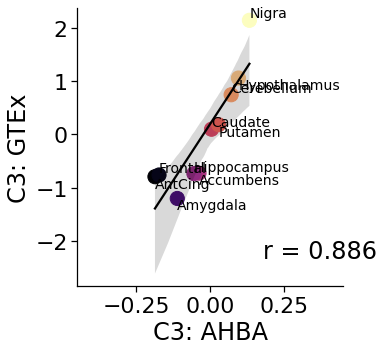

========== ctrl ==========
r = 0.947, p = 0.0


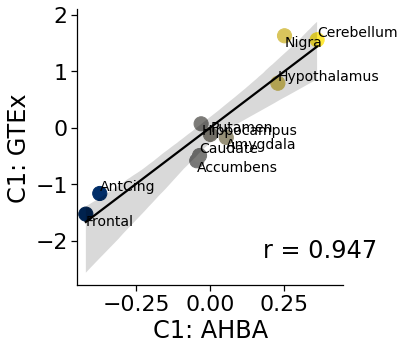

r = 0.962, p = 0.0


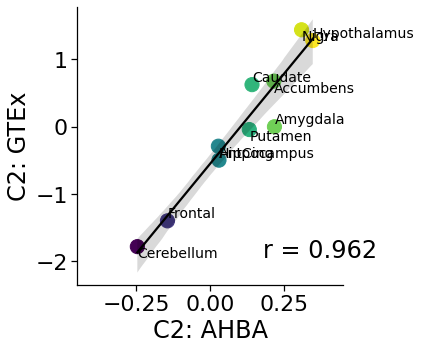

r = 0.866, p = 0.001


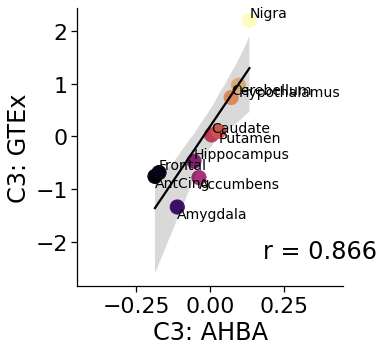

========== yctrl ==========
r = 0.955, p = 0.0


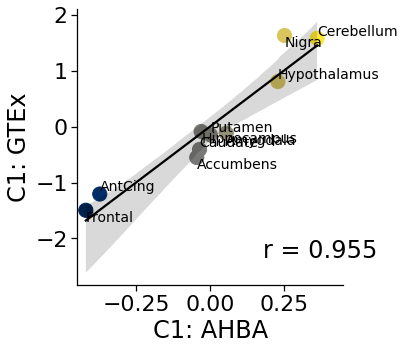

r = 0.964, p = 0.0


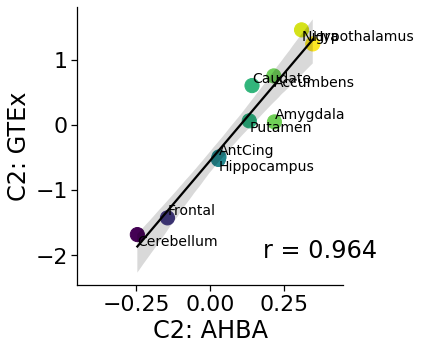

r = 0.889, p = 0.001


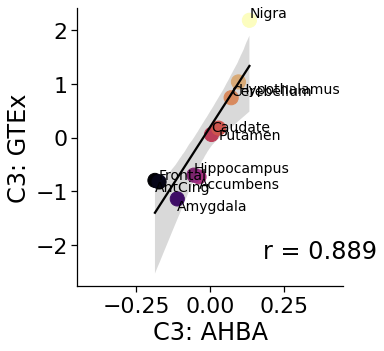

In [51]:
# Run replication analysis and plot

fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'
sns.set_context('notebook',font_scale=2)

# color scales for lines
pals = ['cividis','viridis','magma'] 

# used to control location of text within plot
# I havent messed with this in awhile as I ended up moving the text
# manually after creating the figure. Like a pleb.
scale = {1:0.02,2:0.015,3:0.008} 

# for each dataset
for nm,gtC in datasets.items(): 
    print('%s %s %s'%(('='*10),nm,('='*10)))
    # for each PLS component
    for i in range(1,4):
        # standardize data (because no intercept) -- pattern expression
        vals = StandardScaler().fit_transform(gtC.loc[:,'C%s'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
        gtC.loc[:,'zC%s'%i] = vals
        ## !!CHANGE PATH!!##
        # Load Allen component data
        allen = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GCorr_GTexComp_ABA_C%s_data.csv'%i
                               ).sort_values('GTeX_div')
        allen.index = allen.GTeX_div.values
        allen.drop('Pallidum',axis=0,inplace=True)
        # concatenate GTEx and AHBA data for seaborn plotting
        plotr = pandas.concat([pandas.Series(allen['Component%s_Expresion'%i
                                                  ].values),
                               pandas.Series(gtC['zC%s'%i].values)],
                              axis=1)
        plotr.columns = ['Allen','GTEx']
        plotr.index = allen.GTeX_div.values

        # add pretty colors (...for continuity!)
        # normalize colorscale of markers by AHBA values
        cmap = sns.color_palette(pals[i-1],as_cmap=True)
        sg = plotr.Allen.values
        scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
        norm = Normalize(vmin=np.min(scaled_sg), 
                                           vmax=np.max(scaled_sg))
        cscale = cmap(norm(scaled_sg))
        
        # plot it
        g = sns.lmplot(x='Allen',y='GTEx',data=plotr,
               scatter_kws={'marker':'o','s':200,'color':cscale},
                      line_kws={'color':'k'})
        # get the inter-dataset correlations
        r,p = stats.pearsonr(plotr.Allen.values,plotr.GTEx.values)
        print('r = %s, p = %s'%(round(r,3),round(p,3)))

        # add text indicating which brain region each marker is
        for it,div in enumerate(plotr.sort_values('Allen').index):
            x = plotr.loc[div,'Allen']
            y = plotr.loc[div,'GTEx']
            dist = len(div)*scale[i]#.02
            if it%2==0:
                plt.text(x, y,div,{'size':14},va='top')
            else:
                plt.text(x, y,div,{'size':14},va='bottom',
                         )
        # decorate
        plt.xlabel('C%s: AHBA'%i)
        plt.ylabel('C%s: GTEx'%i)
        plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
        plt.xlim(-.45,.45)
        #plt.savefig(os.path.join(fig_dir,'GTEx_Repl_%s_C%s.pdf'%(nm,i)), bbox_inches='tight')
        plt.show()

# Add brain divisions

In [52]:
# C1

tele = ['Brain - Cortex','Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
        'Brain - Frontal Cortex (BA9)','Brain - Putamen (basal ganglia)',
        'Brain - Hippocampus','Brain - Anterior cingulate cortex (BA24)',
        'Brain - Amygdala']
dien = ['Brain - Hypothalamus']
met = ['Brain - Substantia nigra']
mes = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere']

divs = [tele, dien, met, mes]
names = ['Tele', 'Dien', 'Met', 'Mes',] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'DevOrigin'] = name

# C2
cortex = ['Brain - Cortex','Brain - Cerebellum',
         'Brain - Cerebellar Hemisphere',
         'Brain - Frontal Cortex (BA9)','Brain - Hippocampus',
         'Brain - Anterior cingulate cortex (BA24)',]
noncortex = ['Caudate (basal ganglia)',
             'Brain - Nucleus accumbens (basal ganglia)',
            'Brain - Putamen (basal ganglia)','Brain - Hypothalamus',
             'Brain - Amygdala','Brain - Substantia nigra']
divs = [cortex,noncortex]
names = ['Cortex','NonCortex'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'Cortex'] = name

# C3
assoc = ['Brain - Cortex','Brain - Frontal Cortex (BA9)',
        'Brain - Anterior cingulate cortex (BA24)']
lbf = ['Brain - Nucleus accumbens (basal ganglia)',
      'Brain - Hippocampus','Brain - Amygdala']
bg = ['Caudate (basal ganglia)','Brain - Putamen (basal ganglia)',
     ]
other = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere',
        'Brain - Hypothalamus','Brain - Substantia nigra']

divs = [assoc,lbf,bg,other]
names = ['Association','Limbic/BF','BasalGanglia','Other'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'CortType'] = name

# Widen dataframes for individual analysis

We can apply the same logic above to measure individual correspondence to Allen components. In other words, now that we know the Allen components replicate in GTEx, we can look at replication at an individual level. Since GTEx has a wide age range, we can look to see whether and how the manifestation of these components changes with age

In [59]:
# For each component, make a subject x region matrix
# and keep track of number of valid regions for each subject
gpdfs = {}
for i in range(1,4):
    gpdf = pred[['SUBJID','C%s'%i,'Div']
              ].set_index(['SUBJID'],append=True
                         ).pivot_table(index='SUBJID',
                                       columns='Div',
                                       values='C%s'%i)
    
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [60]:
# an example
print(gpdfs[1].shape)
gpdfs[1].head()

(376, 11)


Div,Accumbens,Amygdala,AntCing,Caudate,Cerebellum,Frontal,Hippocampus,Hypothalamus,Nigra,Putamen,n_valid
SUBJID,,,,,,,,,,,
GTEX-1117F,NaN,NaN,NaN,NaN,NaN,-6.666732,NaN,NaN,NaN,NaN,1.0
GTEX-111FC,NaN,NaN,NaN,NaN,15.704045,-7.945171,NaN,NaN,NaN,NaN,2.0
GTEX-1128S,NaN,NaN,NaN,NaN,10.318082,-14.417177,NaN,NaN,NaN,NaN,2.0
GTEX-117XS,NaN,NaN,NaN,NaN,15.272678,-18.229702,NaN,NaN,NaN,NaN,2.0
GTEX-1192X,-6.202431,NaN,NaN,-7.635442,19.134386,-19.670452,NaN,1.701625,NaN,1.136387,6.0


# Individual congruence

Here, we use similar code above to define the correlation between each subject's regional component expression to the expression of that component in the AHBA. We exclude all individuals with less than 6 valid regions

In [61]:
# for each component
for c in range(1,4):
    cdf = gpdfs[c]
    # load allen regional daata
    # !!CHANGE PATH!!
    allen = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GCorr_GTexComp_ABA_C%s_data.csv'%c
                           ).sort_values('GTeX_div')
    allen.index = allen.GTeX_div.values
    allen.drop('Pallidum',axis=0,inplace=True)
    avec = allen.loc[cdf.columns[:-1]]
    # for each subjects
    for i,row in cdf.iterrows():
        # build a correlation df
        forcorr = pandas.DataFrame(allen,copy=True)
        # exclude subjects with <6 regions available
        if row['n_valid'] > 5:
            # calculate subject - AHBA correlation
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['Component%s_Expresion'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['Component%s_Expresion'%c].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

Now we summarize everything into one convenient dataframe

In [62]:
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = df.groupby('SUBJID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

Now we save this spreadsheet, because we do all the analysis in the C_BrainSpanValidation notebook

In [423]:
# Save this spreadsheet to open it 
# !!CHANGE PATH!!
subsum.to_csv('/Users/jacobv/Science/PLS_GXP/GTEx_IndivCongruence.csv')

A quick random look at relationship between component expression and brainweight, though this doesn't make into the paper (too much overlap with Jakob's project)

r=0.051, p=0.4594


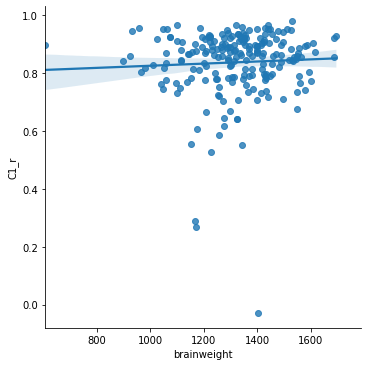

r=0.027, p=0.701


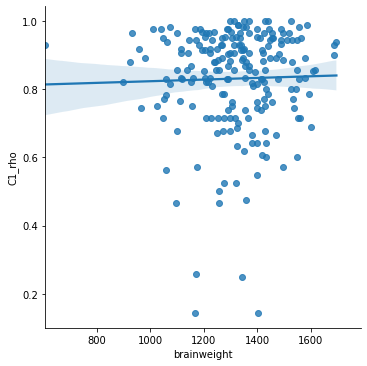

r=0.139, p=0.0439


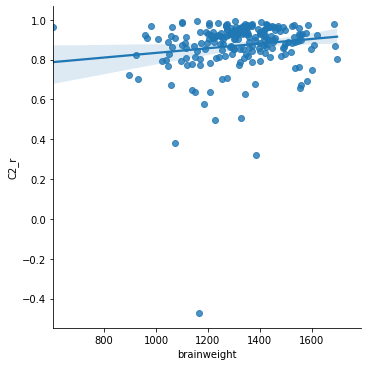

r=0.142, p=0.04


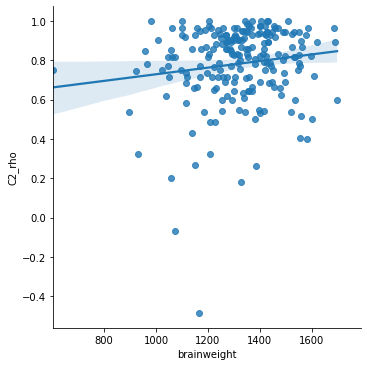

r=0.145, p=0.0349


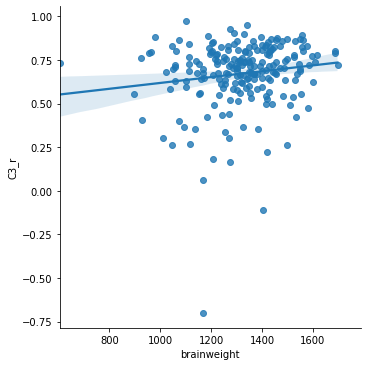

r=0.15, p=0.029


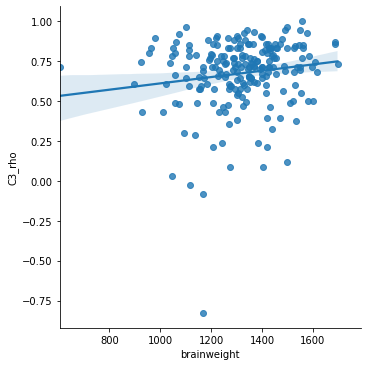

In [411]:
for c in range(1,4):
    sns.lmplot(x='brainweight',y='C%s_r'%c,
                #hue='SEX',
                #lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'brainweight']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.brainweight.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    plt.show()
    sns.lmplot(x='brainweight',y='C%s_rho'%c,
                #hue='SEX',
                #lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_rho'%c,'brainweight']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_rho'%c].values,
                      plotr.brainweight.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    plt.show()